# EDA

- 남녀 비율 확인
- 연령대 비율 확인
- 마스크 착용 여부 비율 Wear : Incorrect : NotWear = 5 : 1 : 1

### 데이터 저장 위치
- **이미지 위치**: '/opt/ml/input/data/train/images'
- **metadata 위치**: '/opt/ml/input/data/train/train.csv'

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import timm

import glob
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import transforms

from PIL import Image
import cv2

In [2]:
path = '/opt/ml/input/data/train/train.csv'
meta_data = pd.read_csv(path)

In [ ]:
meta_data.head(3)

### 1. 남녀 비율 확인

In [ ]:
meta_data

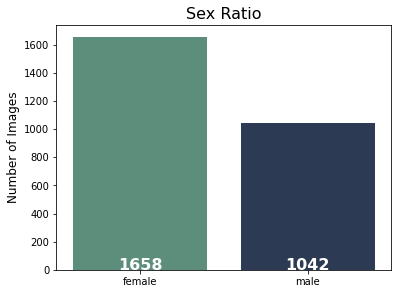

In [4]:
plt.figure(figsize=(6, 4.5))
ax = sns.countplot(x='gender', data=meta_data, palette=["#55967e", "#263959"])

plt.xticks(np.arange(2), ['female', 'male'])
plt.title('Sex Ratio', fontsize=16)
plt.xlabel('')
plt.ylabel('Number of Images', fontsize=12)

counts = meta_data['gender'].value_counts()
#counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
counts_pct = [f'{elem}' for elem in counts]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment='center', size=16, color='w', fontweight='bold')
    
plt.show()

In [13]:
meta_data['gender'].value_counts()

female    1658
male      1042
Name: gender, dtype: int64

### 2. 연령대 비율 확인

In [5]:
age = sorted(meta_data['age'].unique())
print(age)

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


In [6]:
age_count = dict(meta_data['age'].value_counts())
age_group = [0] * 3
for age, count in age_count.items():
    if 0 < age and age < 30:
        age_group[0] += count
    elif 30 <= age and age < 60:
        age_group[1] += count
    elif 60 <= age:
        age_group[2] += count
        
print(age_group)

[1281, 1227, 192]


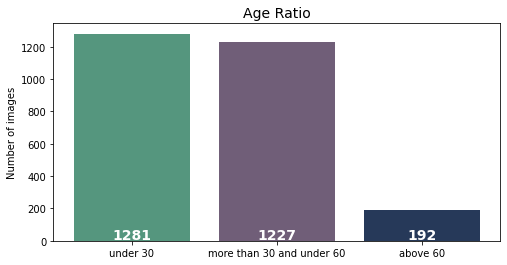

In [7]:
index = ['under 30', 'more than 30 and under 60', 'above 60']
count = age_group

plt.figure(figsize=(8, 4)) 
plt.bar(index, age_group, color=["#55967e", '#705E78', "#263959"])

plt.xticks(np.arange(3), index)
plt.title('Age Ratio', fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')

count = np.array(count)
#counts_pct = [f'{elem * 100:.2f}%' for elem in count / sum(count)]
counts_pct = [f'{elem}' for elem in count]
for i, v in enumerate(counts_pct):
    plt.text(i, 10, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')
    
plt.show()

- female(1)    1658
- male(0)      1042
---
- 0            1281
- 1            1227
- 2            192

In [26]:
from collections import defaultdict

In [31]:
genders = {0: 1042, 1:1685}
ages = {0: 1281, 1: 1127, 2:192}
age_gender = defaultdict(int)

for gender, gender_num in genders.items():
    for age, age_num in ages.items():
        age_gender[age + gender*3] = gender_num + age_num
        
age_gender

defaultdict(int, {0: 2323, 1: 2169, 2: 1234, 3: 2966, 4: 2812, 5: 1877})

In [40]:
index, count = age_gender.keys(), age_gender.values()

sum(count)

13381

In [50]:
a = age_gender.values()
a = np.fromiter(age_gender.values(), dtype=int)
a

array([2323, 2169, 1234, 2966, 2812, 1877])

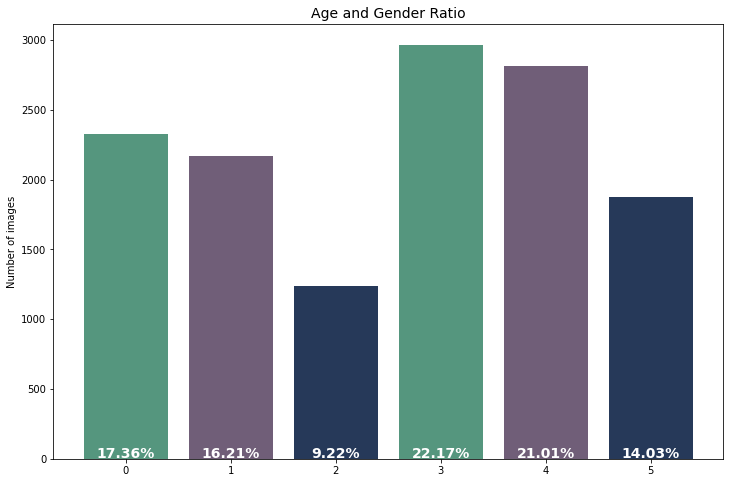

In [52]:
index, count = age_gender.keys(), age_gender.values()

plt.figure(figsize=(12, 8)) 
plt.bar(index, count, color=["#55967e", '#705E78', "#263959"])

plt.xticks(np.arange(len(index)), index)
plt.title('Age and Gender Ratio', fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')

# count = np.array(count[0])
count = np.fromiter(count, dtype=int)
counts_pct = [f'{elem * 100:.2f}%' for elem in count / sum(count)]
# counts_pct = [f'{elem}' for elem in count]
for i, v in enumerate(counts_pct):
    plt.text(i, 10, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')
    
plt.show()

### 3.마스크 착용 비율 시각화

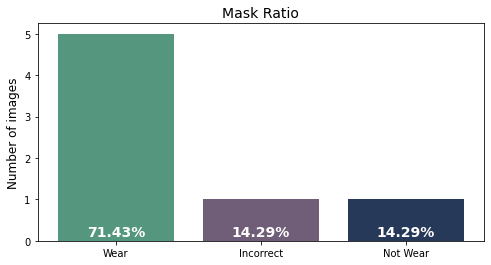

In [12]:
index = ['Wear', 'Incorrect', 'Not Wear']
count= [5, 1, 1]

plt.figure(figsize=(8, 4))
plt.bar(index, count, color=["#55967e", '#705E78', "#263959"])

plt.xticks(np.arange(3), index)
plt.title('Mask Ratio', fontsize=14)
plt.xlabel('')
plt.ylabel('Number of images', fontsize=12)

count = np.array(count)
counts_pct = [f'{elem * 100:.2f}%' for elem in count / sum(count)]
for i, v in enumerate(counts_pct):
    plt.text(i, 0.1, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')
    
plt.show()

In [9]:
# 이미지 path 저장

img_dir = glob.glob('/opt/ml/input/data/train/images/*')

class_num = 18
classes = [[] for _ in range(class_num)]

for path in img_dir:
    # gender와 age에 따라 class 설정
    info = path.split('/')[-1].split('_')
    gender, age = info[1], int(info[3])
    c = 0
    if gender == 'female':
        c += 3
        
    if 30 <= age and age < 60:
        c += 1
    elif 60 <= age:
        c += 2
    
    new_c = c
    img_paths = glob.glob(os.path.join(path, '*'))
    for img_path in img_paths:
        c = new_c
        if 'incorrect' in img_path:
            c += 6
        elif 'normal' in img_path:
            c += 12
        classes[c].append(img_path)

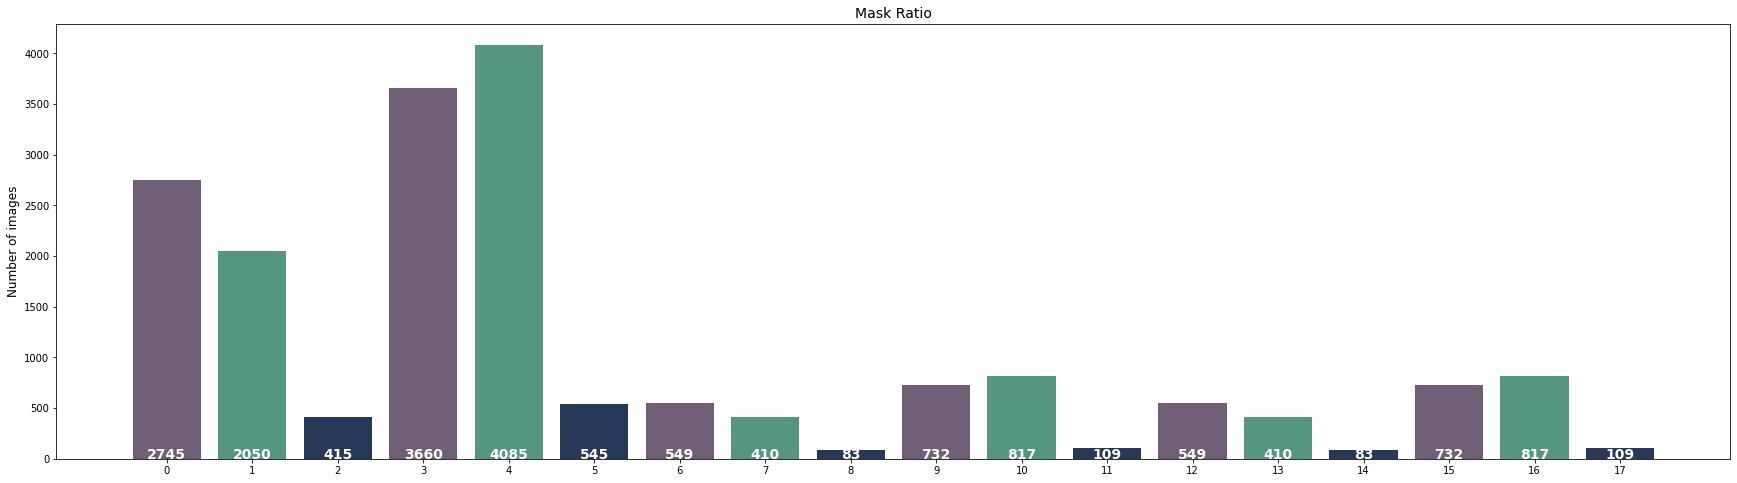

In [10]:
index = list(range(18))
count= list(map(len, classes))

colors = ['#705E78', 
          '#55967e', '#263959']

plt.figure(figsize=(30, 8))
plt.bar(index, count, color=colors)

plt.xticks(np.arange(18), index)
plt.title('Mask Ratio', fontsize=14)
plt.xlabel('')
plt.ylabel('Number of images', fontsize=12)

count = np.array(count)
#counts_pct = [f'{elem * 100:.2f}%' for elem in count / sum(count)]
counts_pct = [f'{elem}' for elem in count]
for i, v in enumerate(counts_pct):
    plt.text(i, 0.1, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')
    
plt.show()

# Dataset

In [21]:
# torchvision.transform

class AgeDataset(Dataset):
    def __init__(self, train_images_path, transform=None):
        self.images_path = train_images_path
        self.size = len(self.images_path)
        self.transform = transform
        
    def __getitem__(self, index):
        """
        input : index
        output: (image tenor(width x heigth x channel), label)
        """
            
        path = self.images_path[index]
        label = self.get_label(path)

        if self.transform:
            img = Image.open(path)  # PIL Image
            img = self.transform(img)
        
        else:
            img = cv2.imread(path)  # type: numpy.ndarray, dtype: unit8, H x W x C
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        return (img, label)
    
    def __len__(self):
        # 고정해서 출력하는 것이 좋을까? - self.size
        # 그 떄 그 때 측정하는 것이 좋을까? 혹시 누가 삭제하면,, ㅜㅜ - len(self.train_images_path)
        return self.size
    
    def get_label(self, path):
        """
        input : path
            ex. '/opt/ml/input/data/train/images/000523_female_Asian_51/incorrect_mask.jpg'
        output: label
        """

        age = int(path.split('/')[-2].split('_')[3])
        if age < 30:
            label = 0
        elif 30 <= age and age < 60:
            label = 1
        elif 60 <= age:
            label = 2

        return label

In [ ]:
# torchvision.transform

class GenderDataset(Dataset):
    def __init__(self, train_images_path, transform=None):
        self.images_path = train_images_path
        self.size = len(self.images_path)
        self.transform = transform
        
    def __getitem__(self, index):
        """
        input : index
        output: (image tenor(width x heigth x channel), label)
        """
            
        path = self.images_path[index]
        label = self.get_label(path)

        if self.transform:
            img = Image.open(path)  # PIL Image
            img = self.transform(img)
        
        else:
            img = cv2.imread(path)  # type: numpy.ndarray, dtype: unit8, H x W x C
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        return (img, label)
    
    def __len__(self):
        # 고정해서 출력하는 것이 좋을까? - self.size
        # 그 떄 그 때 측정하는 것이 좋을까? 혹시 누가 삭제하면,, ㅜㅜ - len(self.train_images_path)
        return self.size
    
    def get_label(self, path):
        """
        input : path
            ex. '/opt/ml/input/data/train/images/000523_female_Asian_51/incorrect_mask.jpg'
        output: label
        """
 
        gender = path.split('/')[-2].split('_')[1]
        
        if gender == 'male':
            label = 0
        elif gender == 'female':
            label = 1

        return label

In [ ]:
# torchvision.transform

class MaskDataset(Dataset):
    def __init__(self, train_images_path, transform=None):
        self.images_path = train_images_path
        self.size = len(self.images_path)
        self.transform = transform
        
    def __getitem__(self, index):
        """
        input : index
        output: (image tenor(width x heigth x channel), label)
        """
            
        path = self.images_path[index]
        label = self.get_label(path)

        if self.transform:
            img = Image.open(path)  # PIL Image
            img = self.transform(img)
        
        else:
            img = cv2.imread(path)  # type: numpy.ndarray, dtype: unit8, H x W x C
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        return (img, label)
    
    def __len__(self):
        # 고정해서 출력하는 것이 좋을까? - self.size
        # 그 떄 그 때 측정하는 것이 좋을까? 혹시 누가 삭제하면,, ㅜㅜ - len(self.train_images_path)
        return self.size
    
    def get_label(self, path):
        """
        input : path
            ex. '/opt/ml/input/data/train/images/000523_female_Asian_51/incorrect_mask.jpg'
        output: label
        """
 
        mask_info = path.split('/')[-1]
        if 'mask' in mask_info:
            label = 0
        elif 'incorrect' in mask_info:
            label = 1
        elif 'normal' in mask_info:
            label = 2

        return label

In [19]:
# 이미지 path 저장

img_dir = glob.glob('/opt/ml/input/data/train/images/*')
train_images_path = []

for path in img_dir:
    img_path = glob.glob(os.path.join(path, '*'))
    train_images_path.extend(sorted(img_path))
len(train_images_path)

18900

In [23]:
# Dataset and Data Loader
transform = transforms.Compose([
    transforms.ToTensor(),
])

age_dataset = AgeDataset(train_images_path, transform=transform)
age_dataloader = DataLoader(age_dataset, batch_size=16, drop_last=True, pin_memory=True, shuffle=True, num_workers=4)

# gender_dataset = GenderDataset(train_images_path, transform=transform)
# gender_dataloader = DataLoader(gender_dataset, batch_size=16, drop_last=True, pin_memory=True, shuffle=True, num_workers=4)

# mask_dataset = MaskDataset(train_images_path, transform=transform)
# mask_dataloader = DataLoader(mask_dataset, batch_size=16, drop_last=True, pin_memory=True, shuffle=True, num_workers=4)

# Model

- efficientnet_b0: 작은 모델

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [55]:
age_model = timm.create_model('efficientnet_b0', pretrained=True)
age_model.classifier

Linear(in_features=1280, out_features=1000, bias=True)

In [15]:
num_classes = 3
age_model = timm.create_model('efficientnet_b0', pretrained=True)
age_model.classifier = nn.Sequential(
    nn.Linear(1280, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, num_classes),
)

In [ ]:
num_classes = 2
gender_model = timm.create_model('efficientnet_b0', pretrained=True)
gender_model.classifier = nn.Sequential(
    nn.Linear(1280, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, num_classes),
)

In [ ]:
num_classes = 3
mask_model = timm.create_model('efficientnet_b0', pretrained=True)
mask_model.classifier = nn.Sequential(
    nn.Linear(1280, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, 1000),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1000, num_classes),
)

# Train

In [24]:
model = age_model
model.to(device)
train_loader = age_dataloader

weight = [1, 1, 6]
weight = torch.tensor(weight).float().cuda()

criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1):
    model.train()
    for iter, (img, label) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        img, label = img.float().cuda(), label.long().cuda()
        pred_logit = model(img)

        loss = criterion(pred_logit, label)
        loss.backward()
        optimizer.step()

        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)

        train_loss = loss.item()
        train_acc = acc
        
        if iter % 100 == 0:
            print(f"epoch {epoch+1} | iter {iter:5d} | train loss {train_loss:.5f} | train acc {train_acc}")

epoch 1 | iter     0 | train loss 1.10814 | train acc 0.125



KeyboardInterrupt: 

In [ ]:
model = gender_model
model.to(device)
train_loader = gender_dataloader

weight = [2, 3]
weight = torch.tensor(weight).float().cuda()

criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1):
    model.train()
    for iter, (img, label) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        img, label = img.float().cuda(), label.long().cuda()
        pred_logit = model(img)

        loss = criterion(pred_logit, label)
        loss.backward()
        optimizer.step()

        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)

        train_loss = loss.item()
        train_acc = acc
        
        if iter % 100 == 0:
            print(f"epoch {epoch+1} | iter {iter:5d} | train loss {train_loss:.5f} | train acc {train_acc}")

In [ ]:
model = mask_model
model.to(device)
train_loader = mask_dataloader

weight = [1, 5, 5]
weight = torch.tensor(weight).float().cuda()

criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(1):
    model.train()
    for iter, (img, label) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        img, label = img.float().cuda(), label.long().cuda()
        pred_logit = model(img)

        loss = criterion(pred_logit, label)
        loss.backward()
        optimizer.step()

        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)

        train_loss = loss.item()
        train_acc = acc
        
        if iter % 100 == 0:
            print(f"epoch {epoch+1} | iter {iter:5d} | train loss {train_loss:.5f} | train acc {train_acc}")

# Test

In [ ]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [ ]:
test_dir = '/opt/ml/input/data/eval'

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    transforms.Resize((512, 384), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

len(dataset)

In [ ]:
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.

age_model.eval()
gender_model.eval()
mask_model.eval()

all_predictions = []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        
        age_pred = age_model(images)
        age_pred = age_pred.argmax(dim=-1)
        
        gender_pred = gender_model(images)
        gender_pred = gender_pred.argmax(dim=-1) * 3
        
        mask_pred = mask_model(images)
        mask_pred = mask_pred.argmax(dim=-1) * 6
        
        pred = age_pred + gender_pred + mask_pred
        
        all_predictions.extend(pred.cpu().numpy())

In [ ]:
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join('.', 'submission.csv'), index=False)
print('test inference is done!')

In [ ]:
submission['ans'].value_counts().sort_index()

In [ ]:
exist_class = np.array(submission['ans'].value_counts().index)
not_exist_class = {}
for i in range(18):
    if i not in exist_class:
        not_exist_class[i] = 0

In [ ]:
not_exist_class = pd.Series(not_exist_class)
answer = submission['ans'].value_counts()

answer = pd.concat([answer, not_exist_class])
answer = answer.sort_index()
answer

In [ ]:
plt.figure(figsize=(20, 6))
ax = sns.barplot(x=np.arange(18), y=answer, palette=['#FEA443', '#F3FEB0', '#F2EDD0'])

plt.xticks(np.arange(18), np.arange(18))
plt.title('Answer Ratio', fontsize=16)
plt.xlabel('')
plt.ylabel('Number of Images', fontsize=12)

counts = answer
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment='center', size=12, color='black', fontweight='bold')
    
plt.show()